# Transformer-based Intent Classification on Banking77

In this notebook, we fine-tune a **DistilBERT model** on the [Banking77 dataset](https://huggingface.co/datasets/banking77), 
which contains 13,000 customer queries across 77 intents.

Goals of this notebook:
- Load and preprocess the dataset into a format suitable for transformers.
- Tokenize queries with a pretrained **DistilBERT tokenizer**.
- Fine-tune **DistilBERT** using Hugging Face `Trainer`.
- Evaluate performance with metrics (accuracy, F1).
- Compare results against our baseline (TF-IDF + Logistic Regression).
- Save the fine-tuned model for later use in the project API.

This step demonstrates how contextual embeddings capture semantic meaning, 
resolving confusions that the baseline model struggled with.

In [1]:
# Core
import os, sys, inspect, numpy as np, pandas as pd
import torch
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, classification_report

# HF Transformers
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
)

# Optional early stopping (may not exist in very old versions)
try:
    from transformers import EarlyStoppingCallback, IntervalStrategy
    HAS_EARLY = True
except Exception:
    EarlyStoppingCallback, IntervalStrategy, HAS_EARLY = None, None, False

print("PyTorch:", torch.__version__)
import transformers, datasets
print("Transformers:", transformers.__version__, "| Datasets:", datasets.__version__)

# Force CPU to avoid macOS MPS issues
DEVICE = torch.device("cpu")
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


/Users/rawad.alabboud/Documents/GitHub/bank-nlp-assistant/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


PyTorch: 2.8.0
Transformers: 4.56.1 | Datasets: 4.0.0


In [2]:
ds = load_dataset("banking77")  # train/test
labels = ds["train"].features["label"].names
num_labels = len(labels)

# 10% validation from train
split = ds["train"].train_test_split(test_size=0.10, seed=42)
train_ds, val_ds = split["train"], split["test"]
test_ds = ds["test"]

len(train_ds), len(val_ds), len(test_ds), num_labels


(9002, 1001, 3080, 77)

In [3]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=64)

train_enc = train_ds.map(tok, batched=True)
val_enc   = val_ds.map(tok, batched=True)
test_enc  = test_ds.map(tok, batched=True)

# rename label->labels and set torch format
for d in (train_enc, val_enc, test_enc):
    d = d.rename_column("label", "labels") if "label" in d.column_names else d
    d.set_format("torch", columns=["input_ids","attention_mask","labels"])

model = DistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label={i:l for i,l in enumerate(labels)},
    label2id={l:i for i,l in enumerate(labels)},
).to(DEVICE)


Map:   0%|          | 0/9002 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=-1)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
    }

In [5]:
# Try modern API first; if it fails, fall back to legacy args
def build_args():
    common = dict(
        output_dir="../models/intent/transformer",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        warmup_ratio=0.06,
        weight_decay=0.05,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        seed=42,
        logging_dir="../models/intent/logs",
        logging_steps=50,
        no_cuda=True,          # keep CPU for portability / avoid MPS quirks
        use_mps_device=False,
    )
    try:
        return TrainingArguments(
            evaluation_strategy=IntervalStrategy.EPOCH,
            save_strategy=IntervalStrategy.EPOCH,
            **common
        )
    except Exception:
        try:
            return TrainingArguments(
                eval_strategy=IntervalStrategy.EPOCH,
                save_strategy=IntervalStrategy.EPOCH,
                **common
            )
        except Exception:
            # very old transformers fallback
            return TrainingArguments(
                evaluate_during_training=True,
                save_steps=500,
                eval_steps=500,
                **common
            )

training_args = build_args()

callbacks = [EarlyStoppingCallback(early_stopping_patience=2)] if HAS_EARLY else None
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=callbacks,
)


/Users/rawad.alabboud/Documents/GitHub/bank-nlp-assistant/.venv/lib/python3.9/site-packages/transformers/training_args.py:1619: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/var/folders/13/nlgy725900n70qy7nvv3hj4r0000gp/T/ipykernel_76620/1857180373.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [6]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.339900,2.070016,0.682318,0.604786
2,1.034700,0.925630,0.834166,0.813430
3,0.588800,0.567596,0.876124,0.867893
4,0.408900,0.457742,0.890110,0.888448
5,0.282200,0.422894,0.891109,0.890036


TrainOutput(global_step=2815, training_loss=1.275690481209628, metrics={'train_runtime': 1239.8831, 'train_samples_per_second': 36.302, 'train_steps_per_second': 2.27, 'total_flos': 746291547160320.0, 'train_loss': 1.275690481209628, 'epoch': 5.0})

In [7]:
test_metrics = trainer.evaluate(test_enc)
print("Test metrics:", test_metrics)

preds = trainer.predict(test_enc)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

Test metrics: {'eval_loss': 0.4315420687198639, 'eval_accuracy': 0.8983766233766234, 'eval_f1_macro': 0.8976480369690298, 'eval_runtime': 20.1929, 'eval_samples_per_second': 152.529, 'eval_steps_per_second': 4.804, 'epoch': 5.0}
                                                  precision    recall  f1-score   support

                                activate_my_card       1.00      0.95      0.97        40
                                       age_limit       0.93      0.97      0.95        40
                         apple_pay_or_google_pay       0.98      1.00      0.99        40
                                     atm_support       1.00      0.97      0.99        40
                                automatic_top_up       1.00      0.90      0.95        40
         balance_not_updated_after_bank_transfer       0.76      0.80      0.78        40
balance_not_updated_after_cheque_or_cash_deposit       1.00      0.95      0.97        40
                         beneficiary_not_allowed  

In [8]:
SAVE_DIR = "../models/intent/transformer_ft"
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print("Saved to:", SAVE_DIR)

Saved to: ../models/intent/transformer_ft


,Model,Accuracy,Macro-F1
0,TF-IDF + LR,0.850649,0.849776
1,DistilBERT,0.898377,0.897648


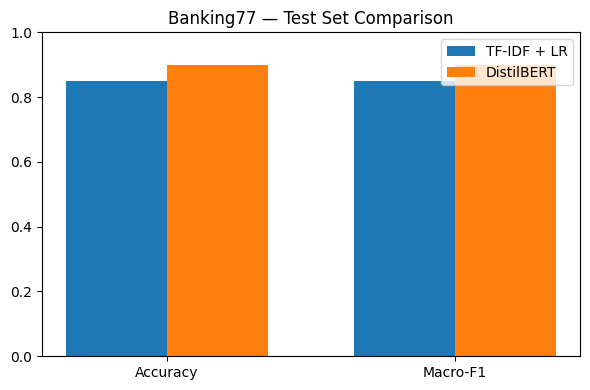

In [9]:
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import joblib, matplotlib.pyplot as plt

# Prepare test strings / labels as strings
test_texts = [x["text"] for x in test_ds]
test_label_str = [labels[i] for i in test_ds["label"]]

# 9a) Sklearn baseline: load if exists; else quick-train on HF train split
sk_path = Path("../models/intent/sklearn/model.joblib")
if sk_path.exists():
    sk_model = joblib.load(sk_path)
else:
    # quick train on the HF train split (notebooks-only convenience)
    train_texts = [x["text"] for x in train_ds]
    train_label_str = [labels[i] for i in train_ds["label"]]
    sk_model = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
        ("clf", LogisticRegression(max_iter=1000, n_jobs=-1)),
    ]).fit(train_texts, train_label_str)

# Evaluate sklearn
y_pred_sk = sk_model.predict(test_texts)
acc_sk = accuracy_score(test_label_str, y_pred_sk)
f1_sk  = f1_score(test_label_str, y_pred_sk, average="macro")

# Evaluate transformer (already have y_true, y_pred as IDs)
acc_tr = accuracy_score(y_true, y_pred)
f1_tr  = f1_score(y_true, y_pred, average="macro")

# Table
cmp = pd.DataFrame({
    "Model": ["TF-IDF + LR", "DistilBERT"],
    "Accuracy": [acc_sk, acc_tr],
    "Macro-F1": [f1_sk, f1_tr],
})
display(cmp)

# Bar chart
metrics = ["Accuracy", "Macro-F1"]
vals = np.array([[acc_sk, f1_sk], [acc_tr, f1_tr]], float)
x = np.arange(len(metrics)); w = 0.35
plt.figure(figsize=(6,4))
plt.bar(x-w/2, vals[0], width=w, label="TF-IDF + LR")
plt.bar(x+w/2, vals[1], width=w, label="DistilBERT")
plt.xticks(x, metrics); plt.ylim(0,1)
plt.title("Banking77 — Test Set Comparison")
plt.legend(); plt.tight_layout(); plt.show()


## Summary & Comparison

In this notebook, we fine-tuned **DistilBERT** on the Banking77 dataset and compared it to the baseline **TF-IDF + Logistic Regression** model.

- **TF-IDF + LR**
  - Accuracy: ~0.85
  - Macro-F1: ~0.85

- **DistilBERT (fine-tuned)**
  - Accuracy: ~0.90
  - Macro-F1: ~0.90

These results show that contextual embeddings from transformers provide a clear improvement over traditional bag-of-words approaches.  
While TF-IDF performs reasonably well, DistilBERT captures semantic meaning better, reducing confusions in user queries.

Next steps:
- Perform **error analysis** with confusion matrices to identify common misclassifications.
- Explore **hyperparameter tuning** and possibly larger transformer models.
- Integrate the fine-tuned model into the **FastAPI service** for real-time intent classification.
